# Sprawozdanie z zajęć nr 9
## Programowanie Równolegle i Rozproszone 2022/2023
### Uniwersytet w Białymstoku
### Karol Wójcik
### 80292

#1. Dokonaj przekształcenia plików z wygenerowaną sceną 3D do postaci plików graficznych,
#które wyświetlisz.
#2. Przedstaw na wykresach porównanie czasów wykonania programów na GPU (Colab) oraz
#CPU (Colab oraz komputer stacjonarny, kod należy napisać na podstawie dostępnej wersji
#programu na GPU) w zależności od rozmiaru problemu (stała DIM). W optymalnym
#przypadku wykresy powinny zostać wyświetlone z matplotlib bezpośrednio w Colab.
#3. Zrealizuj pracę w postaci sprawozdania w Google Colab – dokonaj także opisu programów i
#zrealizowanych czynności – ma to mieć postać tutoriala dla osoby, która nie na  związku z
#przedmiotem

# Zapraszam na dysk w którym są zdjecia wygenerowanymi kulami Jedno zdjecie z podstawowymi kulami, drugie lekko zmodyfikowane

https://drive.google.com/drive/folders/1DzqlUiPvbAacNRjjvMXClgZyVZ3zfoKk?usp=sharing


## 1. zmiana środowiska wykonawczego z CPU na GPU 
## Środowisko wykonawcze - > Zmień typ środowiska wykonawczego - > GPU - > ZAPISZ
## 2. Instalacja i sprawdzenie wersji 


In [3]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-p3budhlt
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-p3budhlt
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=7f8e3963ed3666843f9a52bb3bcc3e2c0ea392d728c3efb0771421aa2632c6fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-ufwg6z_t/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
cr

# GPU 
### Wersja na GPU 

### Wykorzystujaca karte graficza

# Opis programu

## 1. %%cu - wykorzystane by moc kompilowac kod cuda w Google Collab 
## 2. Definicje Preprocesora i zaimportowanie biblioteki
## 3. Stworzenie Struktury Sphere, reprezentuje ona kule w przestrzeni 3D
## 4. if w Sphere
### Warunek dx*dx + dy*dy < radius*radius sprawdza, czy 
### odległość piksela od środka kuli jest mniejsza od promienia kuli. Jeśli tak, to promień przecina się z kulą.

### Zmienna dz jest obliczana jako pierwiastek kwadratu odległości (sqrtf( radius*radius - dx*dx - dy*dy )). Jest to wysokość przecięcia promienia z kulą.

### Zmienna n jest wskaźnikiem do zmiennej, do której kernel zapisze kąt padania promienia na powierzchnię kuli. Kąt ten jest obliczany jako stosunek wysokości przecięcia do promienia kuli (dz / sqrtf( radius * radius )).

### Wartość zwracana przez fragment kodu to wysokość przecięcia promienia z kulą (dz) powiększona o współrzędną z kuli (z).

### Jeśli promień nie przecina się z kulą, to warunek dx*dx + dy*dy < radius*radius jest fałszywy i fragment kodu nie jest wykonywany. W takim przypadku kernel zwraca wartość -INF, co oznacza, że promień nie przecina się z żadnym obiektem.
## 5.
### Kernel kernel jest funkcją CUDA, która jest wykonywana na karcie graficznej. Ma ona dwa argumenty: wskaźnik do tablicy obiektów typu Sphere oraz wskaźnik do tablicy kolorów pikseli. Dla każdego pikselu kernel przeprowadza symulację promienia światła przechodzącego przez scenę i oblicza kolor danego piksela na podstawie obiektów, z którymi promień ten się przecina. W szczególności, dla każdego pikselu kernel wyznacza pozycję piksela w przestrzeni 3D i dla każdej kuli w tablicy sprawdza, czy promień wyznaczony przez pozycję piksela przecina się z kulą. Jeśli tak, to kernel oblicza kolor piksela na podstawie koloru kuli i przeprowadzonego przecięcia oraz zapisuje wynik w tablicy kolorów pikseli.

## 6.
### Funkcja main jest główną funkcją programu i jest wykonywana na procesorze (host). Jej głównym zadaniem jest przygotowanie danych i parametrów potrzebnych do uruchomienia jądra kernel na karcie graficznej oraz zapisanie wyniku do pliku.

### W szczególności:

### Tworzone są zmienne bitmap i dev_bitmap, które reprezentują tablicę kolorów pikseli oraz odpowiednik tej tablicy zarezerwowany w pamięci karty graficznej.

### Alokowana jest pamięć na karcie graficznej dla tablicy kolorów pikseli oraz dla tablicy obiektów Sphere.

### Tworzona jest tablica temp_s obiektów Sphere, która jest inicjalizowana losowymi danymi i kopiowana do pamięci karty graficznej.

### Uruchamiane są zdarzenia start i stop, które służą do mierzenia czasu wykonania kernela.

### Uruchamiane jest jądro kernel z odpowiednimi parametrami.

### Po zakończeniu pracy jądra pobierane są wyniki z pamięci karty graficznej i zapisywane do pliku.

### Zwalniane są zarezerwowane zasoby (pamięć na karcie graficznej i zdarzenia).

### 7. save to file zapisuje plik do plik .ppm

 

In [7]:
%%cu
#include <stdio.h>
#define DIM 6000
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f

struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    __device__ float hit( float ox, float oy, float *n ) {
        float dx = ox - x;
        float dy = oy - y;
        if (dx*dx + dy*dy < radius*radius) {
            float dz = sqrtf( radius*radius - dx*dx - dy*dy );
            *n = dz / sqrtf( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
#define SPHERES 20


__global__ void kernel( Sphere *s, unsigned char *ptr ) {
    // map from threadIdx/BlockIdx to pixel position
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x + y * blockDim.x * gridDim.x;
    float   ox = (x - DIM/2);
    float   oy = (y - DIM/2);

    float   r=0, g=0, b=0;
    float   maxz = -INF;
    for(int i=0; i<SPHERES; i++) {
        float   n;
        float   t = s[i].hit( ox, oy, &n );
        if (t > maxz) {
            float fscale = n;
            r = s[i].r * fscale;
            g = s[i].g * fscale;
            b = s[i].b * fscale;
            maxz = t;
        }
    } 

    ptr[offset*4 + 0] = (int)(r * 255);
    ptr[offset*4 + 1] = (int)(g * 255);
    ptr[offset*4 + 2] = (int)(b * 255);
    ptr[offset*4 + 3] = 255;
}

struct DataBlock{
    unsigned char *dev_bitmap;
};

void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("RayTracingGPU.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}


int main(void) {

  // capture the start time 
  // capture the start time 
  cudaEvent_t start, stop;
  cudaEventCreate( &start );
  cudaEventCreate( &stop);
  
  DataBlock data;
  unsigned char *bitmap = (unsigned char*)malloc(DIM* DIM*4* sizeof(unsigned char));
  int image_size = DIM* DIM*4;
  unsigned char *dev_bitmap;

  cudaMalloc((void**)&dev_bitmap, image_size); 
  data.dev_bitmap=dev_bitmap;
  Sphere *s;

// allocate memory for the Sphere dataset

cudaMalloc((void**)&s, sizeof(Sphere)* SPHERES );

// allocate temp memory, initialize it, copy to

// memory on the GPU, then free our temp memory

Sphere *temp_s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );

for (int i=0; i<SPHERES; i++) {
     temp_s[i].r = rnd( 1.0f);
     temp_s[i].g= rnd( 1.0f);
     temp_s[1].b= rnd( 1.0f);
     temp_s[i].x =rnd( 1000.0f)- 500;
     temp_s[i].y =rnd( 1000.0f) - 500;
     temp_s[1].z = rnd( 1000.0f) - 500;
     temp_s[i].radius = rnd( 100.0f) + 20;
     cudaMemcpy( s, temp_s, sizeof(Sphere)* SPHERES, cudaMemcpyHostToDevice);
     free( temp_s);
}

dim3 block(16, 16);
dim3 grid((DIM + block.x - 1) / block.x, (DIM + block.y - 1) / block.y);

// capture the start time 
cudaEventRecord( start, 0);

// execute the kernel
kernel<<<grid, block>>>(s, dev_bitmap);

// capture the stop time
cudaEventRecord( stop, 0);
cudaEventSynchronize(stop);
float elapsedTime;
cudaEventElapsedTime(&elapsedTime, start, stop);


cudaMemcpy( bitmap, dev_bitmap, image_size, cudaMemcpyDeviceToHost);
printf("Time: %f ms\n", elapsedTime);
float elapsed_time;
cudaEventElapsedTime(&elapsed_time, start, stop);
printf("Time: %.3f milliseconds\n", elapsed_time);

save_to_file(bitmap);




}



Time: 11.296800 ms
Time: 11.297 milliseconds



# Wersja na CPU

## Wykorzystujaca procesor

# Opis programu

## 1. %%cu - wykorzystane by moc kompilowac kod cuda w Google Collab 
## 2. Definicje Preprocesora i zaimportowanie biblioteki
## 3. Stworzenie Struktury Sphere, reprezentuje ona kule w przestrzeni 3D 
## 3.1. if w Sphere
### Warunek dx*dx + dy*dy < radius*radius sprawdza, czy 
### odległość piksela od środka kuli jest mniejsza od promienia kuli. Jeśli tak, to promień przecina się z kulą.

### Zmienna dz jest obliczana jako pierwiastek kwadratu odległości (sqrtf( radius*radius - dx*dx - dy*dy )). Jest to wysokość przecięcia promienia z kulą.

### Zmienna n jest wskaźnikiem do zmiennej, do której kernel zapisze kąt padania promienia na powierzchnię kuli. Kąt ten jest obliczany jako stosunek wysokości przecięcia do promienia kuli (dz / sqrtf( radius * radius )).

### Wartość zwracana przez fragment kodu to wysokość przecięcia promienia z kulą (dz) powiększona o współrzędną z kuli (z).

### Jeśli promień nie przecina się z kulą, to warunek dx*dx + dy*dy < radius*radius jest fałszywy i fragment kodu nie jest wykonywany. W takim przypadku kernel zwraca wartość -INF, co oznacza, że promień nie przecina się z żadnym obiektem.
## 4. Funkcja kernel przyjmuje dwa argumenty: wskaźnik do tablicy Sphere i wskaźnik do tablicy pikseli. Zaczyna od przejścia przez wszystkie wiersze i kolumny w obrazie i obliczenia pozycji piksela w przestrzeni 3D. Następnie rzuca promień z pozycji piksela przez środek płaszczyzny obrazu i sprawdza, z którą kulą promień się przecina. Jeśli promień przecina się z kulą, funkcja oblicza odległość od kuli i ustawia kolor piksela na kolor kuli.
## 5.  save to file zapisuje plik do plik .ppm
## 6. main liczy czas , wywoluje funkcje 
## 7. Rózni sie wersja na CPU od GPU tym ze wersja na CPU nie wykorzystuje równoległosci przez co obliczenia sa dłuzsze , W wersji na GPU mamy mapowanie  od threadIdx/BlockIdx do pozycji pixele {
##    int x = threadIdx.x + blockIdx.x * blockDim.x;
##    int y = threadIdx.y + blockIdx.y * blockDim.y;
##    int offset = x + y * blockDim.x * gridDim.x;
## }
## natomiast w wersji na CPU wykorzystuje się petle by przejsc przez pixele 

In [6]:
%%cu
#include <stdio.h>
#define DIM 6000
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f

struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    float hit( float ox, float oy, float *n ) {
        float dx = ox - x;
        float dy = oy - y;
        if (dx*dx + dy*dy < radius*radius) {
            float dz = sqrtf( radius*radius - dx*dx - dy*dy );
            *n = dz / sqrtf( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
#define SPHERES 20


void kernel(Sphere *s, unsigned char *ptr) {
  for (int y = 0; y < DIM; y++) {
    for (int x = 0; x < DIM; x++) {
      int offset = x + y * DIM;
      float ox = (x - DIM / 2);
      float oy = (y - DIM / 2);

      float r = 0, g = 0, b = 0;
      float maxz = -INF;
      for (int i = 0; i < SPHERES; i++) {
        float n;
        float t = s[i].hit(ox, oy, &n);
        if (t > maxz) {
          float fscale = n;
          r = s[i].r * fscale;
          g = s[i].g * fscale;
          b = s[i].b * fscale;
          maxz = t;
        }
      }

      ptr[offset * 4 + 0] = (int)(r * 255);
      ptr[offset * 4 + 1] = (int)(g * 255);
      ptr[offset * 4 + 2] = (int)(b * 255);
      ptr[offset * 4 + 3] = 255;
    }
  }
}


struct DataBlock{
    unsigned char *dev_bitmap;
};

void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("RayTracinggpu.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}
int main(void) {
    
  // capture the start time 
  clock_t start, stop;
  start = clock();
  // allocate memory for the Sphere dataset
  Sphere *s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );
  unsigned char *bitmap = (unsigned char*)malloc(DIM* DIM*4* sizeof(unsigned char));

  // allocate temp memory, initialize it, copy to
  // memory on the GPU, then free our temp memory
  Sphere *temp_s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );
  for (int i=0; i<SPHERES; i++) {
   //  temp_s[i].r = rnd( 1.0f);
   //  temp_s[i].g= rnd( 1.0f);
   //  temp_s[1].b= rnd( 1.0f);
   //  temp_s[i].radius= rnd( 30.0f ) + 10.0f;
   //  temp_s[i].x= rnd( 100.0f ) - 50.0f;
   //  temp_s[i].y= rnd( 100.0f ) - 50.0f;
   //  temp_s[i].z= rnd( 100.0f ) - 50.0f;
    temp_s[i].r = rnd( 1.0f);
     temp_s[i].g= rnd( 1.0f);
     temp_s[1].b= rnd( 1.0f);
     temp_s[i].x =rnd( 1000.0f)- 500;
     temp_s[i].y =rnd( 1000.0f) - 500;
     temp_s[1].z = rnd( 1000.0f) - 500;
     temp_s[i].radius = rnd( 100.0f) + 20;
  }

  memcpy(s, temp_s, sizeof(Sphere)* SPHERES );
  free(temp_s);


  kernel(s, bitmap);

  // capture the stop time
  stop = clock();

  printf("Time: %.7f seconds\n", ((double)(stop-start))/CLOCKS_PER_SEC);
 printf("Time: %.3f milliseconds\n", ((double)(stop-start))/CLOCKS_PER_SEC*1000); 

  // Save the image to a file
  save_to_file(bitmap);

  // free the device memory
  free(s);

  return 0;
}

Time: 6.2142470 seconds
Time: 6214.247 milliseconds



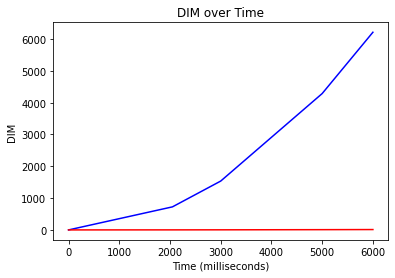

In [8]:
import matplotlib.pyplot as plt


# dodanie do tablic wartosci time i dim  
time_ms_cpu =  [0 , 724.474 ,1536 , 4287,6214.247]
dim_cpu = [0 ,2048 , 3000 , 5000 , 6000]

time_ms_GPU = [0, 1.37 , 3, 7.888320 , 11.297  ]
dim_GPU = [ 0 ,2048 , 3000 , 5000 , 6000 ]

# stowrzenie wykresu funkcja plot
plt.plot( dim_cpu, time_ms_cpu,color='blue', label='CPU')
plt.plot(dim_GPU ,time_ms_GPU  , color='red' , label='GPU' )

# tytyl , os x i y 
plt.xlabel('Time (milliseconds)')
plt.ylabel('DIM')
plt.title('DIM over Time')

# pokaz wykres 
plt.show()

# GPU Czerwona 
# CPU Niebieski